# Importing libraries and modules

In [1]:
import sys
directory_path = "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed"
if directory_path not in sys.path:
    # Add the directory to sys.path
    sys.path.append(directory_path)
    sys.path.append("../")
import os 
import copy
import time
import time
import numpy as np
import argparse

from random_graph import average_neighbor_weights

from torch.utils import data

from utils.utils import *
from utils import load_config
from utils.validate import *
from fedlearning.model import *
from fedlearning.dataset import *
from fedlearning.evolve import *
from fedlearning.optimizer import GlobalUpdater, LocalUpdater, get_omegas
from matplotlib import pyplot as plt
import pickle

import matplotlib.animation as animation
import seaborn as sns

In [2]:
def setup(config_file):
    global config, logger, model, record
    config = load_config(config_file)
    logger = init_logger(config)
    model = init_model(config, logger)
    record = init_record(config, model)

    if config.device == "cuda":
        torch.backends.cudnn.benchmark = True
        # torch.backends.cudnn.deterministic = True

    current_path = os.getcwd()
    if current_path.endswith("notebooks"):
        config.train_data_dir = "../" + config.train_data_dir
        config.test_data_dir = "../" + config.test_data_dir

# Defining Plotting Functions 

In [8]:
def open_dat(fp):
    with open(fp, 'rb') as file:
        log = pickle.load(file)
        return log

def plot_acc_histogram(rec, dataset_name, round_num, save_path=None): 
    accs = np.array(rec["testing_accuracy"])[round_num]
    plt.hist(accs, bins = 20)
    if round_num == -1:
        round_num = len(rec["testing_accuracy"])-1
    plt.title(f"{dataset_name} Testing Accuracy Histogram: Round {round_num}")
    plt.xlabel("Accuracy")
    plt.ylabel("Client Frequency")

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

def get_acc_after_all_avg(rec, config, logger, num=None, shuffle=False):
    # Only uses config to get the test_data and test_labels, so it only matters if the config
    # has the same test data, labels, and model as the one used in the experiment
    dataset = assign_user_data(config, logger)
    test_data = torch.from_numpy(dataset["test_data"]["images"]).to(config.device)
    test_labels = torch.from_numpy(dataset["test_data"]["labels"]).to(config.device)

    clients = list(rec["models"].keys())
    if shuffle: 
        np.random.shuffle(clients)
    if num is None:
        print("Using all clients")
        avged_weights = average_neighbor_weights(clients[0], clients[1:], rec["models"])
    else: 
        avged_weights = average_neighbor_weights(clients[0], clients[1:num], rec["models"])
    test_model = init_model(config, logger)
    test_model.load_state_dict(avged_weights)
    output = test_model(test_data)
    return accuracy_with_output(output, test_labels)

def _get_acc_vs_avg(rec, config, logger, max_num=None, shuffle=False, averaging_order=None, test_data = None, verbose=False):
    # Only uses config to get the test_data and test_labels, so it only matters if the config
    # has the same test data, labels, and model as the one used in the experiment
    dataset = assign_user_data(config, logger)
    
    
    if test_data is None:
        test_images = torch.from_numpy(dataset["test_data"]["images"]).to(config.device)
        test_labels = torch.from_numpy(dataset["test_data"]["labels"]).to(config.device)
    else:
        test_images = test_data[0]
        test_labels = test_data[1]
    
    if averaging_order is not None:
        # averaging order specifies the order in which clients should be averaged
        clients = averaging_order
    else:
        # Get the list of clients
        clients = list(rec["models"].keys())

    # Initialize the test model
    test_model = init_model(config, logger)
    
    if shuffle: 
        np.random.shuffle(clients)
    if max_num is None:
        if verbose: print("Using all clients")
        max_num = len(clients)
    else: 
        if verbose: print(f"Using {max_num} clients")
    

    accrued_accs = []
    w_ = WeightMod(rec["models"][clients[0]].state_dict())
    test_model.load_state_dict(w_.state_dict())
    output = test_model(test_images)
    accrued_accs.append(accuracy_with_output(output, test_labels))

    for i, client in enumerate(clients[1:max_num], 1):
        # Add next client weight
        w_.add(rec["models"][client].state_dict())
        # Normalize the weight
        w_.div(float(i+1))

        # Load the weight into the model and test
        test_model.load_state_dict(w_.state_dict())
        output = test_model(test_images)
        accrued_accs.append(accuracy_with_output(output, test_labels))
        
        # Multiply the normalization back
        w_.mul(float(i+1))
    return accrued_accs

def plot_acc_vs_round(rec, dataset_name, boxplot=False, median=False, 
                      save_path=None, config=None, logger=None, end_round=None, baseline_ntk_fp=None):
    accs = np.array(rec["testing_accuracy"])[:end_round, :]
    print(accs.mean(axis=1))
    print(f"Max Acc: {accs.mean(axis=1).max()}")
    print(f"Final Acc: {accs.mean(axis=1)[-1]}")
    
    if config is not None and logger is not None:
        print(f"Acc after averaging all models: {get_acc_after_all_avg(rec, config, logger)}")
    
    rounds = np.arange(len(accs))
    plt.plot(rounds, accs.mean(axis=1), label="Mean", color="black")
    if boxplot:
        plt.boxplot(accs.T, positions=rounds, showfliers=False, medianprops=dict(color="red"))
    if median:
        plt.plot(rounds, np.median(accs, axis=1), label="Median", color="red")
    plt.title(f"{dataset_name} Average Testing Accuracy vs. Round")
    plt.xlabel("Communication Round")
    plt.xticks(np.arange(0, len(accs)+1, 3), np.arange(0, len(accs)+1, 3))
    plt.ylabel("Accuracy")
    
    
    if baseline_ntk_fp is not None:
        baseline_ntk = open_dat(baseline_ntk_fp)
        baseline_accs = np.array(baseline_ntk["testing_accuracy"])[:end_round]
        plt.plot(baseline_accs, label="Centralized NTK-FL Baseline", color="blue")
    plt.legend()
    
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def save_results_intxt(rec, dataset_name, save_path, config, logger, round=None):
    accs = np.array(rec["testing_accuracy"])
    with open(save_path, "w") as file:
        file.write(f"Dataset: {dataset_name}\n")
        file.write(f"Topology: {rec["topology"]}\n")
        if round is None: 
            file.write(f"Max Acc: {accs.mean(axis=1).max():.3f}\n")
        else: 
            file.write(f"Max Acc: {accs.mean(axis=1)[:round].max():.3f}\n")
        file.write(f"Final Acc: {accs.mean(axis=1)[-1]:.3f}\n")
        file.write(f"Final Acc After All Models are Averaged: {get_acc_after_all_avg(rec, config, logger):.3f}\n")
        file.write(f"Rounds: {rec["epoch"]}\n")

def all_save(rec, dataset_name, save_path, config, logger, boxplot=False, median=False):
    plot_acc_vs_round(rec, dataset_name, boxplot=boxplot, median=median, save_path=save_path+"_acc.png")
    plot_acc_histogram(rec, dataset_name, -1, save_path=save_path+"_hist.png")
    save_results_intxt(rec, dataset_name, save_path+"_results.txt", config, logger)

# def plot_accs()

In [4]:
def plot_multiple_accs(fps, labels, title=None, save_path=None, y_lim=None, common_x=True):
    recs_to_compare = [open_dat(fp) for fp in fps]
    
    xs = np.arange(min(
        [len(rec["testing_accuracy"]) for rec in recs_to_compare]
    ))
    length = xs.shape[0]

    for i in range(len(recs_to_compare)):
        if common_x: 
            plt.plot(xs, np.array(recs_to_compare[i]["testing_accuracy"]).mean(axis=1)[:length], label=labels[i])
        else: 
            plt.plot(np.array(recs_to_compare[i]["testing_accuracy"]).mean(axis=1), label=labels[i])

    plt.xlabel("Communication Round")
    plt.ylabel("Accuracy")
    if title == None: 
        plt.title("Comparison of Self-Training Strategies")
    else: 
        plt.title(title)
    plt.legend()
    if y_lim is not None:
        plt.ylim(y_lim)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

# filepaths_to_cmpr = ["/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial8/19_06_04_26.dat",
#                             "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial10/oneround20_06_16_55.dat",
#                                 "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial9/allrounds21_06_02_32.dat"]
# labels = ["No self-training", "One round self-training", "All round self training"]
# plot_multiple_accs(filepaths_to_cmpr, labels, save_path=None, common_x=False)

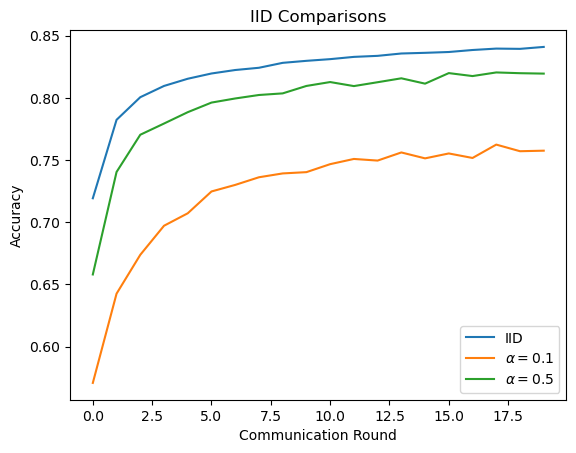

In [10]:
fps_to_cmpr = ["../records/trials/trial1/17_06_15_56.dat", 
                     "../records/trials/trial2/14_06_01_57.dat",
                    "../records/trials/trial3/24_06_04_45.dat"]
labels = ["IID", r"$\alpha=0.1$", r"$\alpha=0.5$"]
fps_to_cmpr = ["../" + fp for fp in fps_to_cmpr]
plot_multiple_accs(fps_to_cmpr, labels, save_path=None, title="IID Comparisons")

In [22]:
rec = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.1.dat")
rec["testing_accuracy"]

[0.7139999866485596,
 0.7787999510765076,
 0.8053999543190002,
 0.8187999725341797,
 0.82669997215271,
 0.8391000032424927,
 0.8278999924659729,
 0.836899995803833,
 0.8416999578475952,
 0.8460999727249146,
 0.8396999835968018,
 0.8468999862670898,
 0.8454999923706055,
 0.8443999886512756,
 0.8511999845504761,
 0.852899968624115,
 0.8495000004768372,
 0.852899968624115,
 0.8526999950408936,
 0.8565999865531921]

In [5]:
main_st_fps = {
    0.5: "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/st_main_1/26_06_11_03.dat", # 0.5
    0.1: "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/st_main_2/26_06_11_31.dat", # 0.1
    -1: "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/st_main_3/26_06_12_09.dat" # IID
}

main_st_recs = {alpha: open_dat(fp) for alpha, fp in main_st_fps.items()}

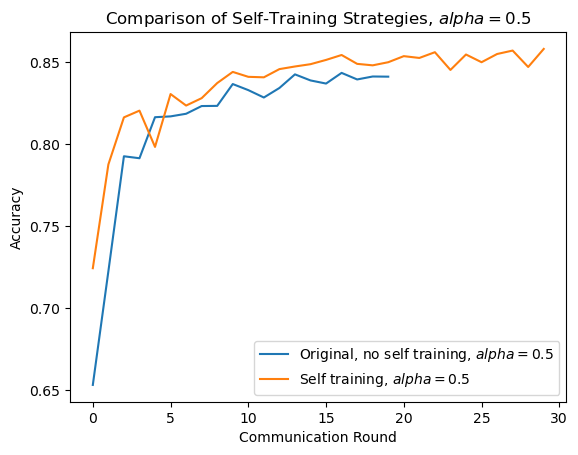

In [6]:
original_alpha05 = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.5.dat")
plt.plot(original_alpha05["testing_accuracy"], label = "Original, no self training, $alpha=0.5$")
plt.plot(main_st_recs[0.5]["testing_accuracy"], label="Self training, $alpha=0.5$")
plt.title("Comparison of Self-Training Strategies, $alpha=0.5$")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.legend()

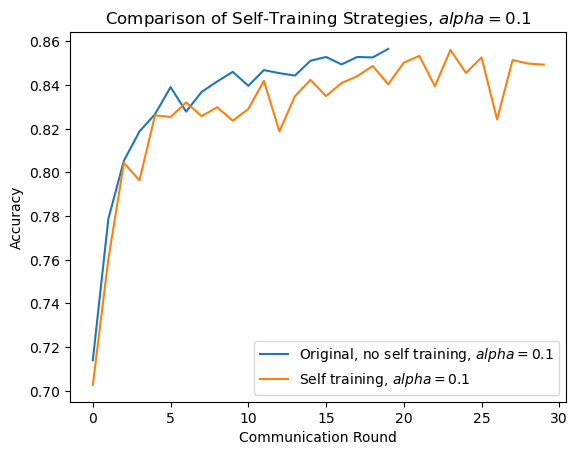

In [20]:
original_alpha01 = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.1.dat")
plt.plot(original_alpha01["testing_accuracy"], label = "Original, no self training, $alpha=0.1$")
plt.plot(main_st_recs[0.1]["testing_accuracy"], label="Self training, $alpha=0.1$")
plt.title("Comparison of Self-Training Strategies, $alpha=0.1$")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.legend()

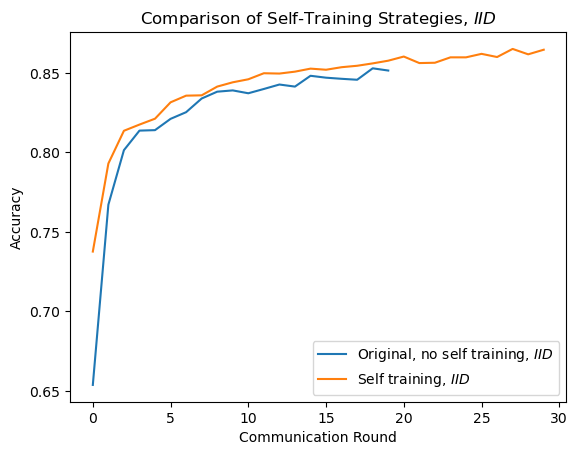

In [21]:
original_alpha01 = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/iid_FAMNIST.dat")
plt.plot(original_alpha01["testing_accuracy"], label = "Original, no self training, $IID$")
plt.plot(main_st_recs[-1]["testing_accuracy"], label="Self training, $IID$")
plt.title("Comparison of Self-Training Strategies, $IID$")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.legend()

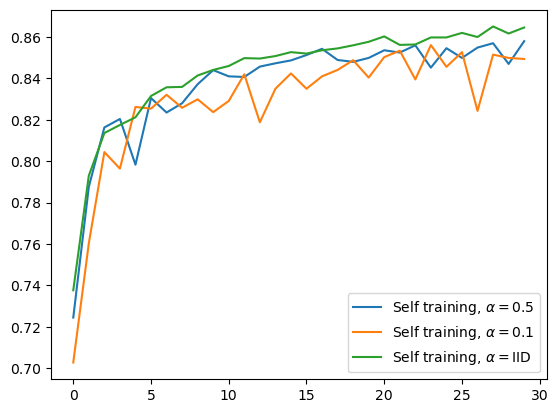

In [24]:
plt.plot(main_st_recs[0.5]["testing_accuracy"], label=r"Self training, $\alpha=0.5$")
plt.plot(main_st_recs[0.1]["testing_accuracy"], label=r"Self training, $\alpha=0.1$")
plt.plot(main_st_recs[-1]["testing_accuracy"], label=r"Self training, $\alpha=\text{IID}$")
plt.legend()
plt.show()

[0.71925765 0.78234565 0.80053098 0.80957598 0.81536698 0.81959531
 0.82238765 0.82419131 0.82815464 0.82976998 0.83112831 0.83294598
 0.83377665 0.83567165 0.83620865 0.83687198 0.83847931 0.83960798
 0.83939698 0.84095498]
Max Acc: 0.8409549788633982
Final Acc: 0.8409549788633982
Using all clients
Acc after averaging all models: 0.8622999787330627


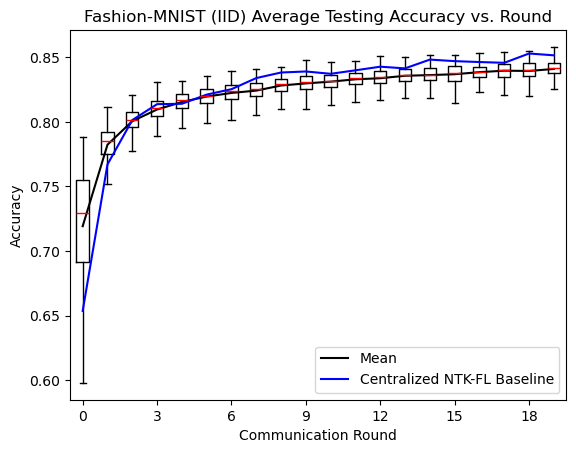

In [9]:
# setup("/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial17/config17.yaml")
fp = "../../records/trials/trial1/17_06_15_56.dat"
rec = open_dat(fp)
plot_acc_vs_round(rec, "Fashion-MNIST (IID)", boxplot=True, median=False, config=config, logger=logger, baseline_ntk_fp="/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/iid_FAMNIST.dat")
# plot_acc_histogram(rec, "Fashion-MNIST", -1, save_path="../../records/trial13/trial13_hist.png")
# save_results_intxt(rec, "Fashion-MNIST", f"../../records/trial13/trial13_results.txt", config, logger)

[0.57080298 0.64257599 0.67381832 0.69717698 0.70719298 0.72473865
 0.73001332 0.73615798 0.73924098 0.74027098 0.74669265 0.75088098
 0.74957431 0.75610598 0.75135631 0.75530231 0.75167431 0.76242265
 0.75709598 0.75753065]
Max Acc: 0.762422647078832
Final Acc: 0.7575306481122971
Using all clients
Acc after averaging all models: 0.8613999485969543


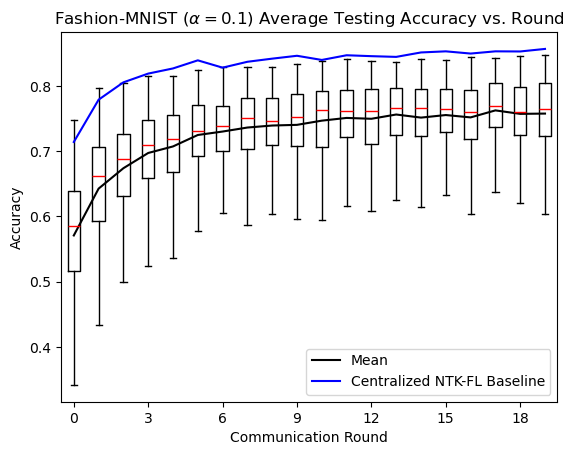

In [12]:
fp = "/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial2/14_06_01_57.dat"
rec = open_dat(fp)
plot_acc_vs_round(rec, "Fashion-MNIST ($\\alpha=0.1$)", boxplot=True, median=False, config=config, logger=logger, baseline_ntk_fp="/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.1.dat", end_round=20)

[0.65800965 0.74041431 0.77034765 0.77935398 0.78848464 0.79620498
 0.79950898 0.80230465 0.80359898 0.80957598 0.81271031 0.80946765
 0.81257098 0.81572031 0.81142831 0.81990398 0.81752531 0.82043965
 0.81982765 0.81949765]
Max Acc: 0.8204396460453669
Final Acc: 0.8194976452986399
Using all clients
Acc after averaging all models: 0.863099992275238


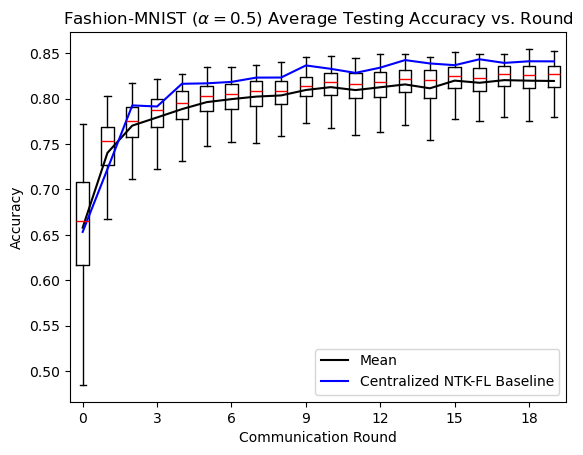

In [11]:
fp = "/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial3/24_06_04_45.dat"
rec = open_dat(fp)
plot_acc_vs_round(rec, "Fashion-MNIST ($\\alpha=0.5$)", boxplot=True, median=False, config=config, logger=logger, baseline_ntk_fp="/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.5.dat", end_round=20)

[0.0635     0.67123265 0.74370598 0.76812031 0.78235798 0.78792998
 0.79675631 0.79957798 0.80472331 0.80540731 0.80661298 0.81091731
 0.81388098 0.81283598 0.81771865 0.81483598 0.81620731 0.81859431
 0.82001198 0.82233298 0.82336331 0.82138998 0.82257598 0.82498898
 0.82556598 0.82490898 0.82680165 0.82651998 0.82718198 0.82869865
 0.82949831]
Max Acc: 0.8294983114798864
Final Acc: 0.8294983114798864
Acc after averaging all models: 0.8618999719619751


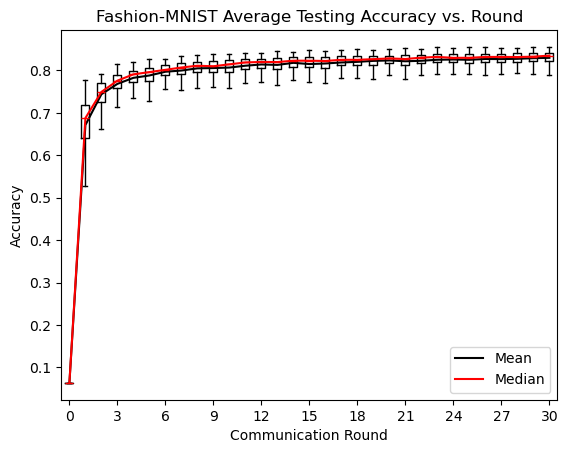

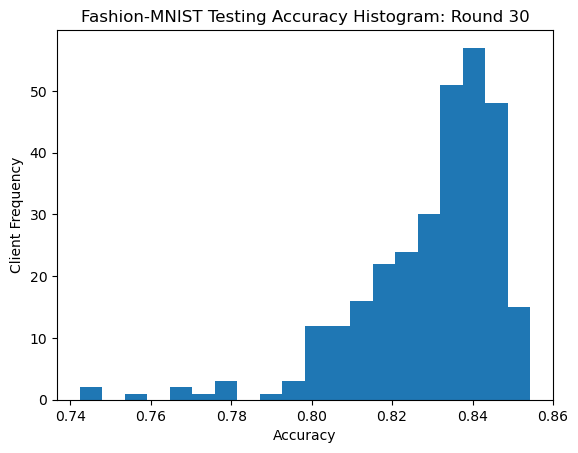

In [53]:
fp = "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial14/28_06_07_16.dat"
rec = open_dat(fp)
plot_acc_vs_round(rec, "Fashion-MNIST", boxplot=True, median=True, config=config, logger=logger, save_path="../../records/trial14/trial14_acc.png")
plot_acc_histogram(rec, "Fashion-MNIST", -1, save_path="../../records/trial14/trial14_hist.png")
save_results_intxt(rec, "Fashion-MNIST", f"../../records/trial14/trial14_results.txt", config, logger)

In [19]:
config_file = "config_random_graph_st.yaml"
config = load_config(config_file)
logger = init_logger(config)
model = init_model(config, logger)
record = init_record(config, model)

if config.device == "cuda":
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

current_path = os.getcwd()
if current_path.endswith("notebooks"):
    config.train_data_dir = "../" + config.train_data_dir
    config.test_data_dir = "../" + config.test_data_dir

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


Creating config from filepath:  /home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils
/home/gathomp3/Deep_Learning/NeuralTangent/records/trial16/train.log


[0.1417     0.68287798 0.75195632 0.77286198 0.78357398 0.79369831
 0.79778698 0.80012832 0.80536365 0.80549431 0.80987498 0.81210898
 0.81312665 0.81476265 0.81593931 0.81738098 0.81747965 0.81751298
 0.82040198 0.82222065 0.82180231 0.82290664 0.82425364 0.82634798
 0.82588931 0.82572831 0.82674965 0.82754631 0.82821798 0.82611365
 0.82850965]
Max Acc: 0.8285096460580825
Final Acc: 0.8285096460580825
Acc after averaging all models: 0.8622999787330627


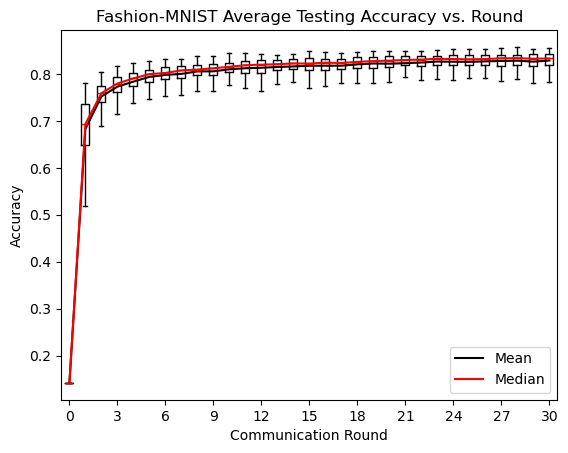

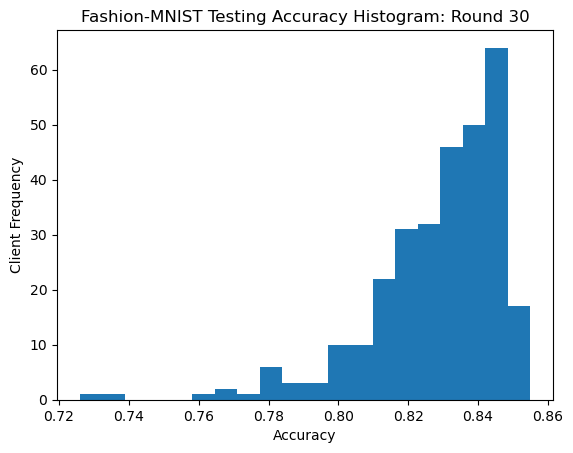

In [37]:
fp = "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial16/01_07_05_25.dat"
rec = open_dat(fp)
plot_acc_vs_round(rec, "Fashion-MNIST", boxplot=True, median=True, config=config, logger=logger, save_path="../../records/trial16/trial16_acc.png")
plot_acc_histogram(rec, "Fashion-MNIST", -1, save_path="../../records/trial16/trial16_hist.png")
save_results_intxt(rec, "Fashion-MNIST", f"../../records/trial16/trial16_results.txt", config, logger)

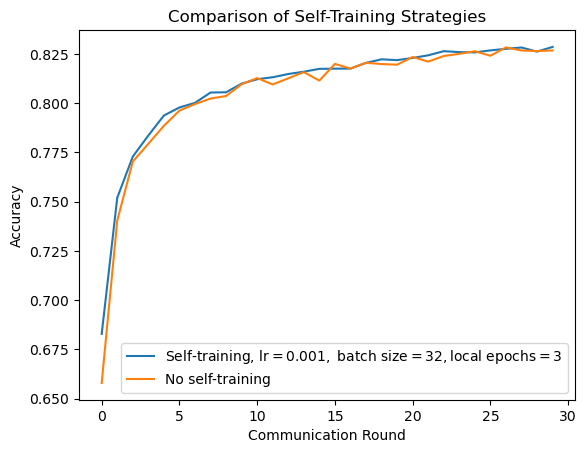

In [39]:
fps =  ["/home/gathomp3/Deep_Learning/NeuralTangent/records/trial16/01_07_05_25.dat", "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial3/24_06_04_45.dat"]
rec = open_dat(fps[0])
plt.plot(np.array(rec["testing_accuracy"]).mean(axis=1)[1:], label=r"Self-training, $\text{lr}=0.001,\ \text{batch size}=32, \text{local epochs}=3$")
rec = open_dat(fps[1])
plt.plot(np.array(rec["testing_accuracy"]).mean(axis=1), label="No self-training")
plt.legend()
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.title("Comparison of Self-Training Strategies")
plt.show()

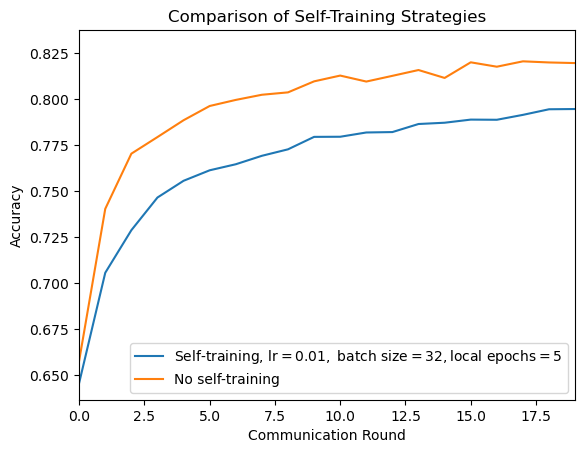

: 

In [45]:
fps =  ["/home/gathomp3/Deep_Learning/NeuralTangent/records/trial13/27_06_01_23.dat", "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial3/24_06_04_45.dat"]
rec = open_dat(fps[0])
plt.plot(np.array(rec["testing_accuracy"]).mean(axis=1)[1:], label=r"Self-training, $\text{lr}=0.01,\ \text{batch size}=32, \text{local epochs}=5$")
rec = open_dat(fps[1])
plt.plot(np.array(rec["testing_accuracy"]).mean(axis=1), label="No self-training")
plt.legend()
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.xlim(0, 19)
plt.title("Comparison of Self-Training Strategies")
plt.show()

# Final Model Averaging

In [13]:
setup("/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial17/config17.yaml")
fps = ["/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial1/17_06_15_56.dat", 
       "/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial2/14_06_01_57.dat",
       "/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial3/24_06_04_45.dat"]
recs = [open_dat(fp) for fp in fps]

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


Creating config from filepath:  /home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils
/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial17/train.log


### IID

KeyboardInterrupt: 

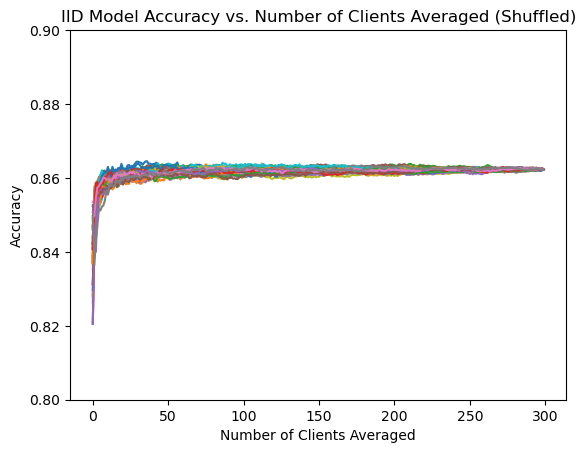

In [27]:
for i in range(100):
    plt.plot(_get_acc_vs_avg(recs[0], config, logger, max_num=300, shuffle=True), label="IID")
    plt.title("IID Model Accuracy vs. Number of Clients Averaged (Shuffled)")
    plt.xlabel("Number of Clients Averaged")
    plt.ylabel("Accuracy")
    plt.ylim(0.80, 0.90)
    # plt.legend()
    # plt.show()

### $\alpha = 0.1$

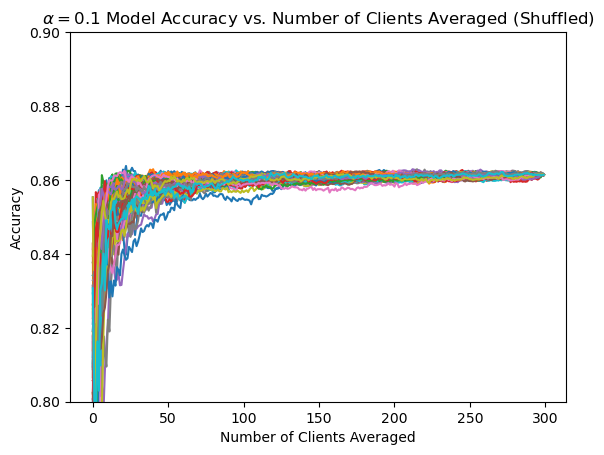

In [ ]:
for i in range(100):
    plt.plot(_get_acc_vs_avg(recs[1], config, logger, max_num=300, shuffle=True), label="IID")
    plt.title("$\\alpha = 0.1$ Model Accuracy vs. Number of Clients Averaged (Shuffled)")
    plt.xlabel("Number of Clients Averaged")
    plt.ylabel("Accuracy")
    plt.ylim(0.80, 0.90)
    # plt.legend()
    # plt.show()

### $\alpha = 0.5$

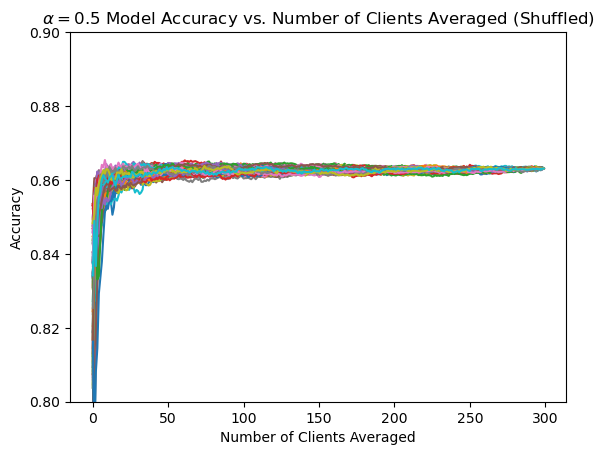

In [106]:
for i in range(100):
    plt.plot(_get_acc_vs_avg(recs[2], config, logger, max_num=300, shuffle=True), label="IID")
    plt.title("$\\alpha = 0.5$ Model Accuracy vs. Number of Clients Averaged (Shuffled)")
    plt.xlabel("Number of Clients Averaged")
    plt.ylabel("Accuracy")
    plt.ylim(0.80, 0.90)
    # plt.legend()
    # plt.show()

## Client Selection Strategy

In [14]:
def get_test_and_val(config, logger, shuffle=True): 
    test_images = assign_user_data(config, logger)["test_data"]["images"]
    test_labels = assign_user_data(config, logger)["test_data"]["labels"]

    if shuffle:
        indices = np.random.permutation(test_images.shape[0])
        test_images = test_images[indices]
        test_labels = test_labels[indices]
        
    # Send to torch
    test_images = torch.from_numpy(test_images).to(config.device)
    test_labels = torch.from_numpy(test_labels).to(config.device)

    # Split into test and val
    split_point = test_images.shape[0]//2

    val_images = test_images[split_point:]
    val_labels = test_labels[split_point:]

    test_images = test_images[:split_point]
    test_labels = test_labels[:split_point]
    
    return (test_images, test_labels), (val_images, val_labels)

(test_images, test_labels), (val_images, val_labels) = get_test_and_val(config, logger)

In [19]:
def sort_clients(rec, config, logger, val_images, val_labels, test_images, test_labels, title=None, save_path=None, x_lim=(0,300), y_lim=(0.85, 0.97), with_histogram=True, figsize=(6,4)):
    client_models = rec["models"]
    val_accs = np.array([accuracy_with_output(client_model(val_images), val_labels) for client_model in client_models.values()])
    test_accs = np.array([accuracy_with_output(client_model(test_images), test_labels) for client_model in client_models.values()])
    
    sorted_clients = np.argsort(val_accs)[::-1]
    
    fig, ax1 = plt.subplots(figsize=figsize)
    
    ax1.plot(_get_acc_vs_avg(rec, config, logger, max_num=300, averaging_order=sorted_clients, test_data=[test_images, test_labels], shuffle=False), label="Best to worst", color="red")
    ax1.plot(_get_acc_vs_avg(rec, config, logger, max_num=300, averaging_order=None, test_data=[test_images, test_labels], shuffle=True), label="Shuffled", color="green")
    ax1.plot(_get_acc_vs_avg(rec, config, logger, max_num=300, averaging_order=sorted_clients[::-1], test_data=[test_images, test_labels], shuffle=False), label="Worst to best", color="blue")
    
    
    ax1.set_xlabel("Number of Clients Averaged", fontsize=12)
    ax1.set_ylabel("Accuracy", fontsize=12)
    ax1.set_ylim(*y_lim)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.set_title(title, fontsize=14)
    
    if with_histogram: 
        # Standardize histogram bins
        hist, bins = np.histogram(test_accs, bins=15, range=y_lim)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bar_width = np.diff(bins)[0] * 0.8  # 80% of bin width
        
        # Plot histogram bars with increased width
        for count, center in zip(hist, bin_centers):
            ax1.barh(center, count, height=bar_width, color='gray', alpha=0.5, align='center')
        
        if x_lim is not None:
            ax1.set_xlim(*x_lim)
        else: 
            ax1.set_xlim(0, 300)
        
        # Adjust label placement and formatting
        ax1.text(0.02, 0.98, "Histogram: Distribution of\nIndividual Client Accuracies", 
                transform=ax1.transAxes, fontsize=10, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add a secondary x-axis for the histogram
        ax2 = ax1.twiny()
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks([])
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)
    
    plt.show()

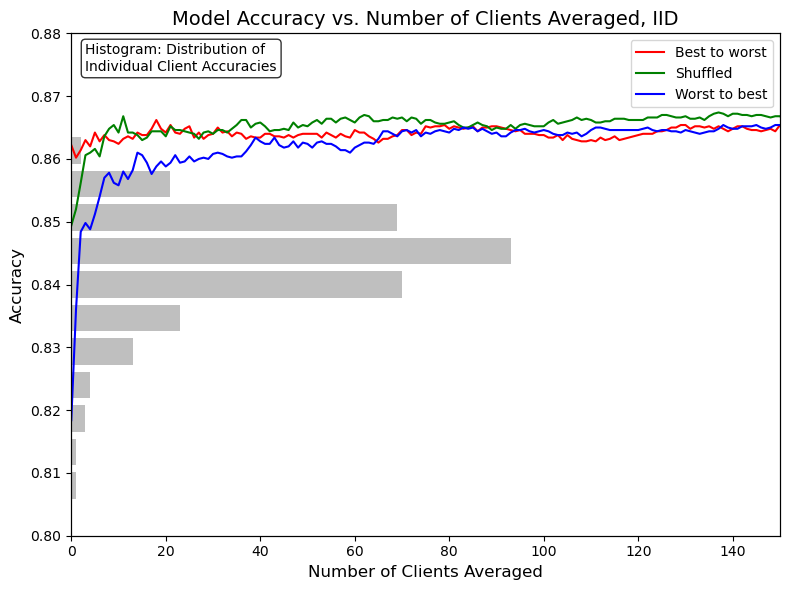

In [20]:
rec_num = 0
rec = recs[rec_num]
title = r"Model Accuracy vs. Number of Clients Averaged, IID"
sort_clients(rec, config, logger, val_images, val_labels, test_images, test_labels, title=title, x_lim=(0,150), y_lim=(0.80,0.88), figsize=(8,6))

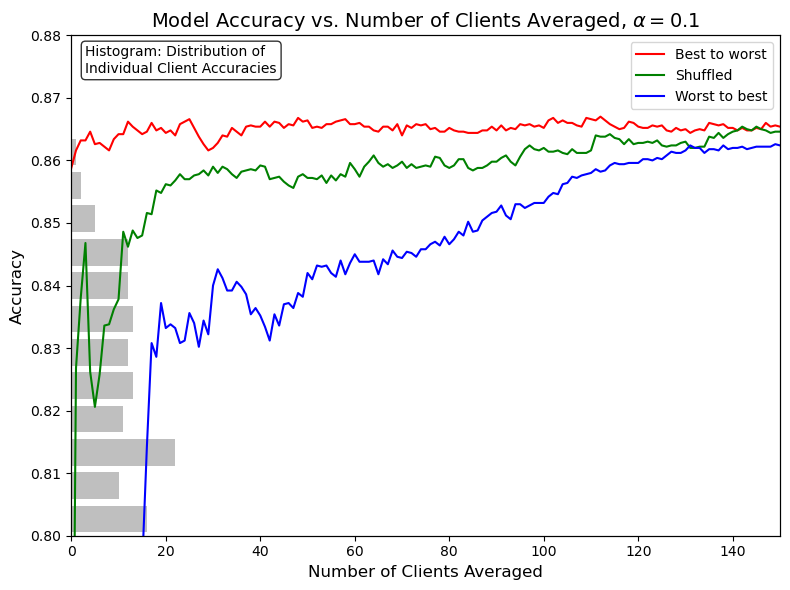

In [25]:
rec_num = 1
rec = recs[rec_num]
title = r"Model Accuracy vs. Number of Clients Averaged, $\alpha = 0.1$"
sort_clients(rec, config, logger, val_images, val_labels, test_images, test_labels, title=title, x_lim = (0, 150), y_lim = (0.80,0.88), with_histogram=True, figsize=(8,6))

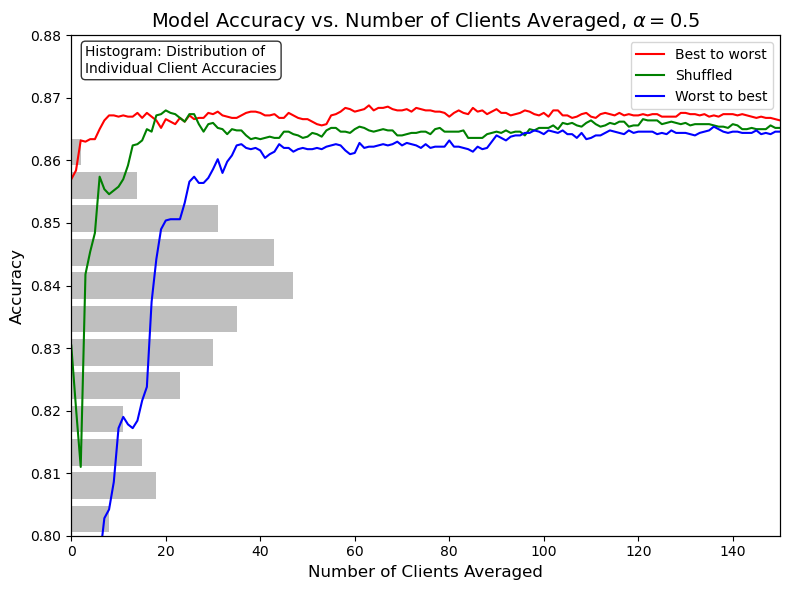

In [27]:
rec_num = 2
rec = recs[rec_num]
title = r"Model Accuracy vs. Number of Clients Averaged, $\alpha = 0.5$"
sort_clients(rec, config, logger, val_images, val_labels, test_images, test_labels, title=title, x_lim = (0, 150), y_lim=(0.80,0.88), figsize=(8,6))

# MNIST Averaging

In [141]:
setup("/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial21/config21.yaml")
fps = ["/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial21/08_07_23_51.dat", # IID
       "/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial20/08_07_13_00.dat" # alpha = 0.1
       ]
recs = [open_dat(fp) for fp in fps]

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
----------------------------

Creating config from filepath:  /home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils
/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial21/train.log


### IID

[0.14749999 0.78796831 0.88295331 0.90513398 0.91664931 0.92432464
 0.93037098 0.93433964 0.93770231 0.94137698 0.94378998 0.94615198
 0.94830331 0.95001331 0.95116298 0.95196331 0.95362698 0.95473698
 0.95564898 0.95657431 0.95770731]
Max Acc: 0.957707309325536
Final Acc: 0.957707309325536
Using all clients
Acc after averaging all models: 0.9656999707221985


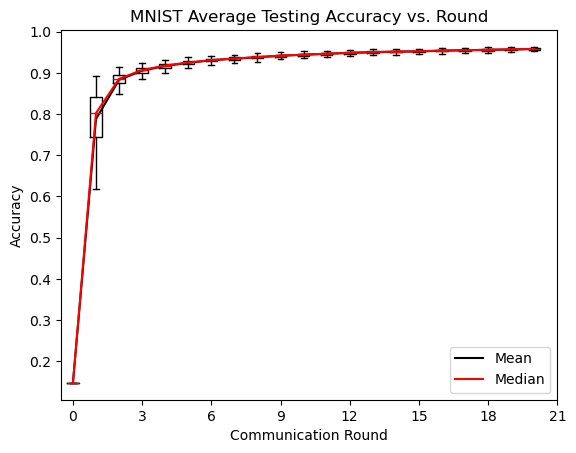

In [142]:
plot_acc_vs_round(recs[0], "MNIST", boxplot=True, median=True, config=config, logger=logger)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
----------------------------

Creating config from filepath:  /home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils
/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial20/train.log
[0.1373     0.65993398 0.77291065 0.81999498 0.84542831 0.86449131
 0.86956631 0.88406031 0.88812964 0.89612631 0.90132631 0.90189664
 0.91093564 0.91154231 0.91513131 0.92083564 0.92169998 0.92385364
 0.92540631 0.93049864 0.93109731]
Max Acc: 0.9310973105827968
Final Acc: 0.9310973105827968
Using all clients
Acc after averaging all models: 0.9554999470710754


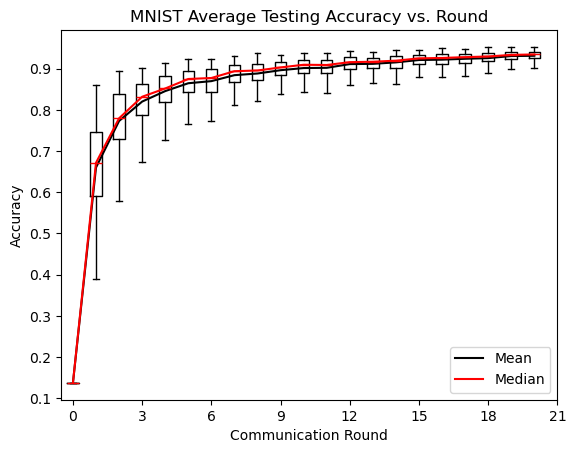

In [143]:
setup("/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial20/config20.yaml")
plot_acc_vs_round(recs[1], "MNIST", boxplot=True, median=True, config=config, logger=logger)

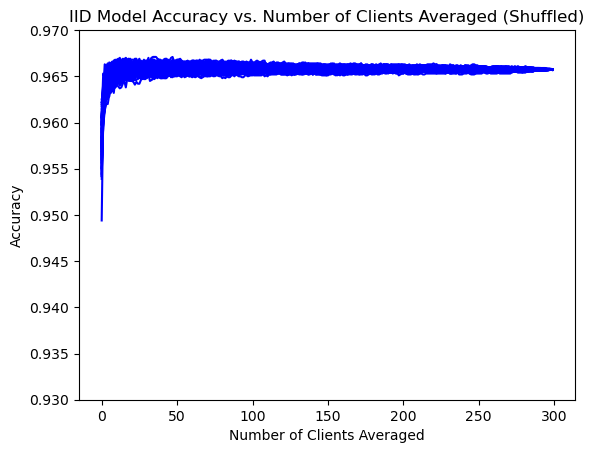

In [144]:
for i in range(100):
    plt.plot(_get_acc_vs_avg(recs[0], config, logger, max_num=300, shuffle=True), color="blue")
    plt.title("IID Model Accuracy vs. Number of Clients Averaged (Shuffled)")
    plt.xlabel("Number of Clients Averaged")
    plt.ylabel("Accuracy")
    plt.ylim(0.93,0.97)
    # plt.legend()
    # plt.show()

### $\alpha = 0.1$

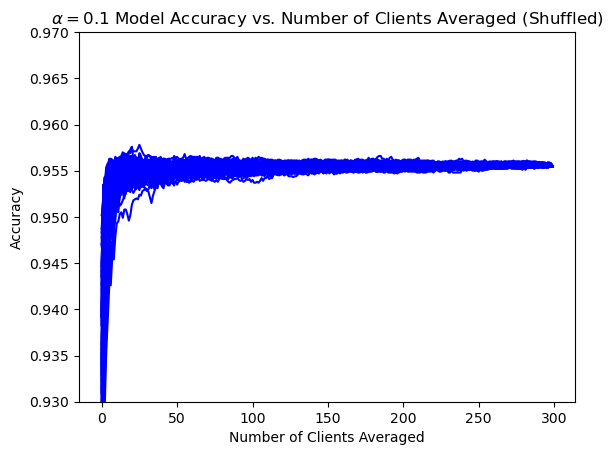

In [145]:
for i in range(100):
    plt.plot(_get_acc_vs_avg(recs[1], config, logger, max_num=300, shuffle=True), color="blue")
    plt.title("$\\alpha = 0.1$ Model Accuracy vs. Number of Clients Averaged (Shuffled)")
    plt.xlabel("Number of Clients Averaged")
    plt.ylabel("Accuracy")
    plt.ylim(0.93,0.97)
    # plt.legend()
    # plt.show()

## Client Selection Strategy

In [146]:
setup("/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial21/config21.yaml")
(test_images, test_labels), (val_images, val_labels) = get_test_and_val(config, logger)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
----------------------------

Creating config from filepath:  /home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils
/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial21/train.log


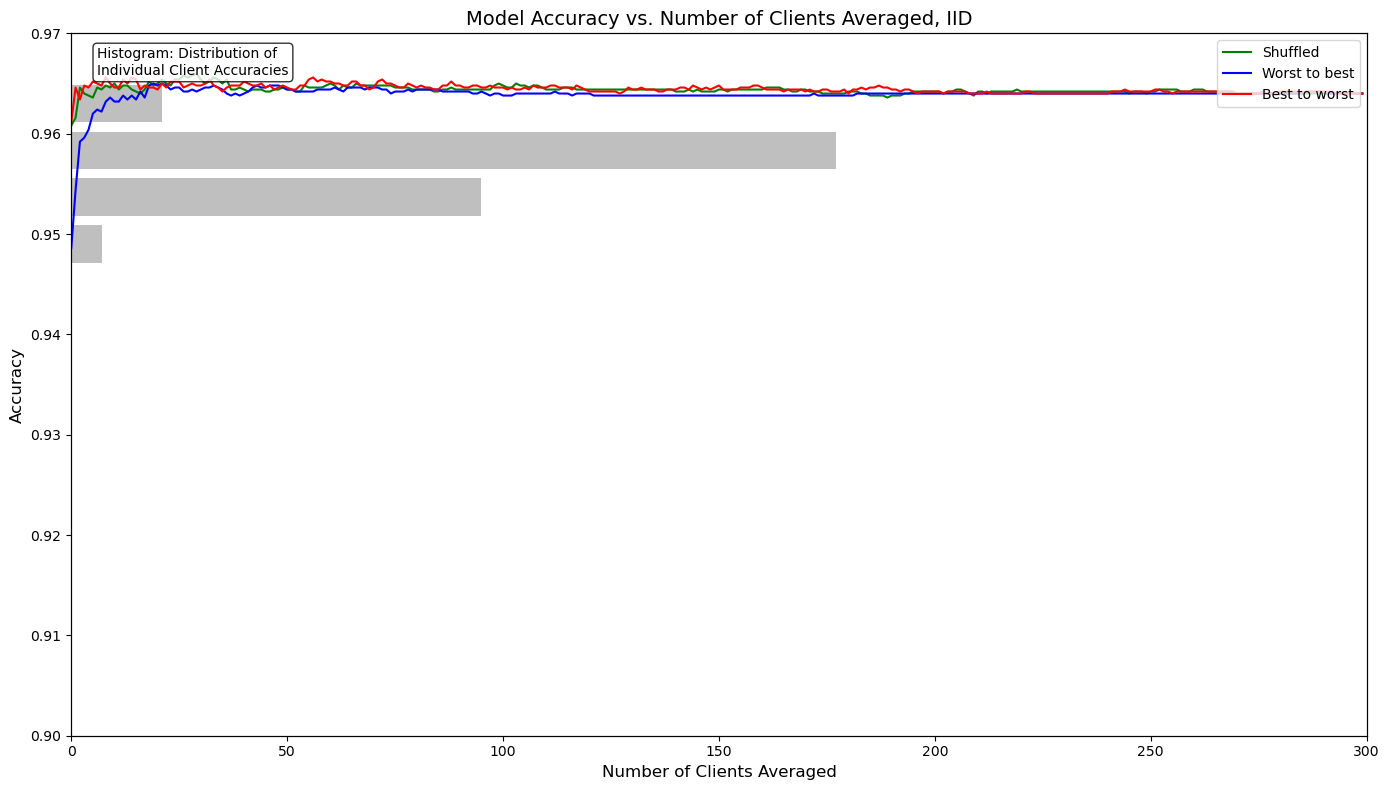

In [147]:
rec_num = 0
rec = recs[rec_num]
title = r"Model Accuracy vs. Number of Clients Averaged, IID"
sort_clients(rec, config, logger, val_images, val_labels, test_images, test_labels, title=title, y_lim=(0.9, 0.97), with_histogram=True)

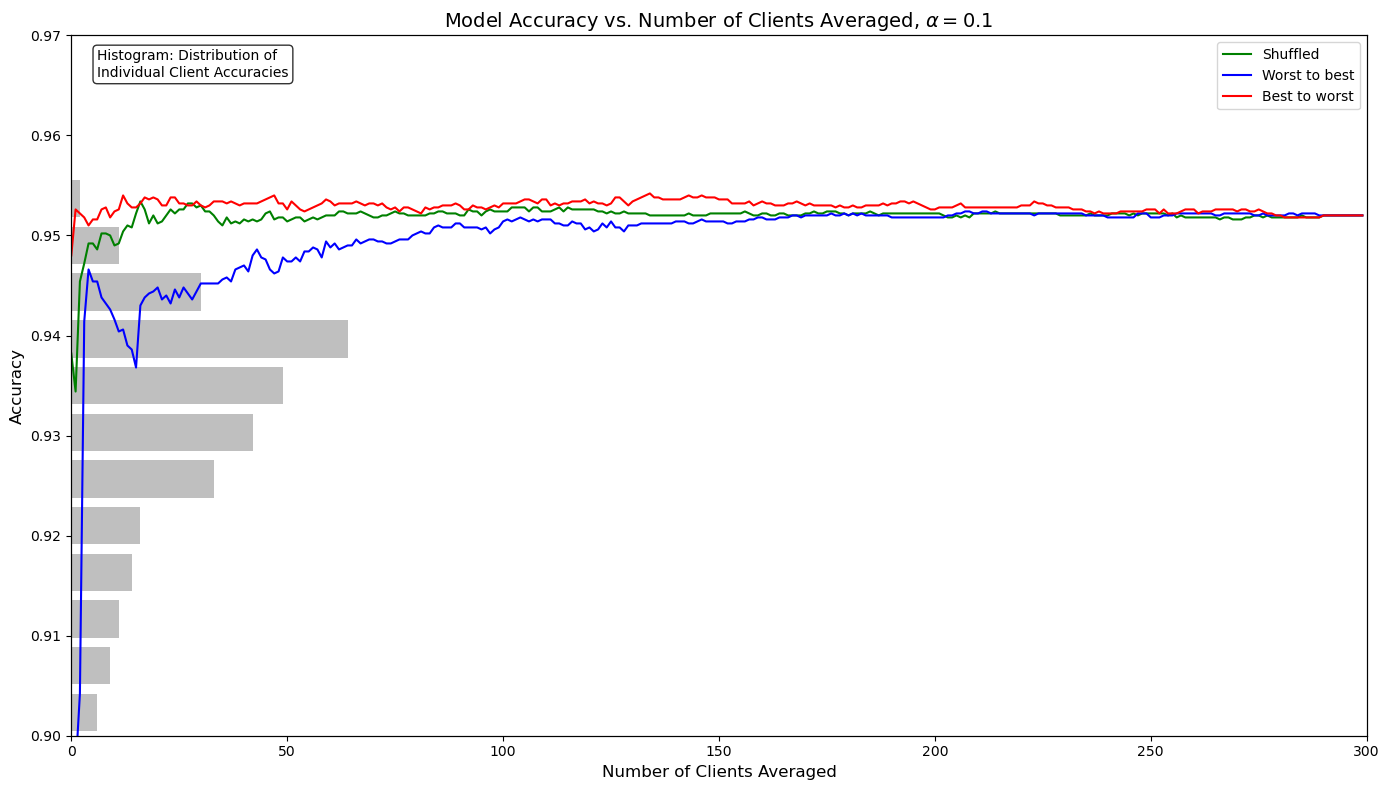

In [149]:
rec_num = 1
rec = recs[rec_num]
title = r"Model Accuracy vs. Number of Clients Averaged, $\alpha = 0.1$"
sort_clients(rec, config, logger, val_images, val_labels, test_images, test_labels, title=title, y_lim=(0.90, 0.97))

In [49]:
setup("/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial20/config20.yaml")
(test_images, test_labels), (val_images, val_labels) = get_test_and_val(config, logger)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


Creating config from filepath:  /home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils
/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial20/train.log


## CNN Results

In [5]:
setup("/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial22/config22.yaml")
fp = "../../records/trials/trial22/12_07_02_01.dat"
rec = open_dat(fp)
# plot_acc_vs_round(rec, "Fashion-MNIST", boxplot=True, median=True, config=config, logger=logger, save_path="../../records/trials/trial22/trial22_acc.png")

--------------------------------------------------------------------------------


Creating config from filepath:  /home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils
/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial22/train.log


In [155]:
save_results_intxt(rec, "Fashion-MNIST", f"../../records/trials/trial22/trial22_results.txt", config, logger)

Using all clients


[1996.66666667 2000.         2000.         2000.         1860.
  985.66666667 1456.          915.          631.66666667  502.66666667]
Max Avg Tau: 2000.0
Final Avg Tau: 502.6666666666667


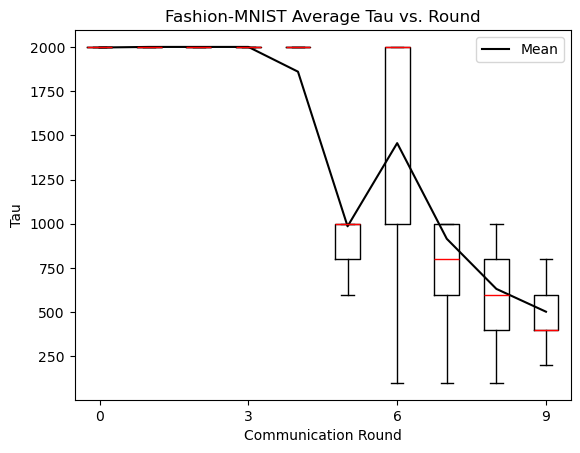

In [160]:

def plot_tau_vs_round(rec, dataset_name, boxplot=False, median=False, 
                      save_path=None, config=None, logger=None, end_round=None):
    accs = np.array(rec["taus"])[1:end_round, :]
    print(accs.mean(axis=1))
    print(f"Max Avg Tau: {accs.mean(axis=1).max()}")
    print(f"Final Avg Tau: {accs.mean(axis=1)[-1]}")
    
    rounds = np.arange(len(accs))
    plt.plot(rounds, accs.mean(axis=1), label="Mean", color="black")
    if boxplot:
        plt.boxplot(accs.T, positions=rounds, showfliers=False, medianprops=dict(color="red"))
    if median:
        plt.plot(rounds, np.median(accs, axis=1), label="Median", color="red")
    plt.title(f"{dataset_name} Average Tau vs. Round")
    plt.xlabel("Communication Round")
    plt.xticks(np.arange(0, len(accs)+1, 3), np.arange(0, len(accs)+1, 3))
    plt.ylabel("Tau")
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

# plt.plot(np.array(rec["taus"]).mean(axis=1)[1:], label="Mean Tau")
plot_tau_vs_round(rec, "Fashion-MNIST", boxplot=True, config=config, logger=logger, median=False)

In [6]:
setup("/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial23/config23.yaml")

--------------------------------------------------------------------------------


Creating config from filepath:  /home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils
/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial23/train.log


In [7]:
rec = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/records/trials/trial23/13_07_18_27.dat")
# save_results_intxt(rec, "Fashion-MNIST", f"../../records/trials/trial23/trial23_results.txt", config, logger)

Using all clients


In [1]:
# plot_acc_histogram(rec, "Fashion-MNIST", -1, save_path="../../records/trials/trial23/trial23_hist.png")

In [2]:
import torchvision.models as models
squeezenet
squeezenet = models.squeezenet1_0()


In [14]:
count = 0
for parameter in squeezenet.parameters():
    count += parameter.numel()

In [15]:
count

1248424

In [17]:
model_parameters = filter(lambda p: p.requires_grad, squeezenet.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

1248424

In [18]:
squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   